In [1]:
sys.path.append("..")
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
labels = utils.generate_labels_from_bins(config.age_bins)
bins = config.age_bins
population = utils.generate_custom_population(config.age_bins, labels)

## Preprocess POLYMOD data

In [4]:
contact = pd.read_csv("../data/contact_data/contact.csv")
hh = pd.read_csv("../data/contact_data/hh.csv")
p = pd.read_csv("../data/contact_data/participant.csv")
day = pd.read_csv("../data/contact_data/day.csv")
contact = contact.merge(p.drop('part_gender', axis=1), on='part_id')
contact = contact.merge(hh, on='hh_id')
contact = contact.merge(day.drop(columns=['sday_id', 'day', 'month', 'year']), on='part_id')
contact.drop(columns=['frequency_multi', 'phys_contact', 'duration_multi', 'cnt_otherplace',
                      'cnt_age_est_min', 'cnt_age_est_max', 'cont_id', 'cnt_gender', 'part_id', "hh_id"], inplace=True)
contact.dropna(inplace=True)
remap = {
    'cnt_age_exact': int,
    'part_age': int,
    'dayofweek': int,
    'cnt_home': bool,
    'cnt_work': bool,
    'cnt_school': bool,
    'cnt_transport': bool,
    'cnt_leisure': bool
}
contact = contact.astype(remap)
contact = contact[['part_age', 'cnt_age_exact', 'cnt_home', 'cnt_work', 'cnt_school', 'cnt_leisure', 'country', 'dayofweek', 'hh_size']]
def renamer():
    current = ['part_age', 'cnt_age_exact', 'cnt_home', 'cnt_work', 'cnt_school', 'cnt_leisure', 'country', 'dayofweek']
    columns = ['contact_age_0','contact_age_1','home','work','school','public','country','dayofweek']
    return {current[i]: columns[i] for i in range(len(current))}
mapper = renamer()
contact.rename(mapper=mapper, axis=1, inplace=True)
contact.sort_values('contact_age_0', inplace=True)

In [5]:
contact.to_csv('../data/age_groups/contact_data.csv', index=False)

## Load contact data
Loading the preprocessed data and reduces into age bins. Contact patterns are here split into four components: **home**, **school**, **work** and **public**. These are denoted $M^H_{ij}$, $M^S_{ij}$, $M^W_{ij}$ and $M^P_{ij}$, respectively.

In [52]:
df = pd.read_csv('../data/age_groups/contact_data.csv')
df.contact_age_0 = pd.cut(df['contact_age_0'], bins=bins+[110], labels=labels, include_lowest=True)
df.contact_age_1 = pd.cut(df['contact_age_1'], bins=bins+[110], labels=labels, include_lowest=True)
df_mat = pd.DataFrame(df[df.columns[:-2]].groupby(['contact_age_0', 'contact_age_1']).sum()).reset_index()

### Different scales to define contact patterns
There exists different scales to define contact patterns. These are in *intensive scale*, *extensive scale* and *density scale*. Intensive scale matrices, denoted $M_{ij}$ expresses the mean number of contacts between age group $i$ and $j$ during a certain period of time. Matrices expressed in extensive scale, denoted $C_{ij}$ gives the total number of contacts between age groups $i$ and $j$. This is given by $$C_{ij} = M_{ij} N_i$$ 

Where $N_i$ is the total population of age group $i$. Lastly, density scale matrices, denoted $F_{ij}$ expresses the fraction of contacts between age groups $i$ and $j$ among all possible contacts that actually takes place. It is given by $$F_{ij} = \frac{C_{ij}}{N_i N_j} = \frac{M_{ij}}{N_j}$$

Where $N_j$ is the total population of age group $j$. We now retrieve the sub-matrices (split into different areas) from the survey, which is given in intensive scale.

In [53]:
M_ij = []
for col in ['home', 'school', 'work', 'public']:
    M_ij.append(pd.pivot_table(df_mat, values=col, index='contact_age_0', columns='contact_age_1').values)

### Density scale transformation
We then transform the matrices given in intensive scale into matrices given in density scale

In [54]:
N_j = df.contact_age_1.value_counts()[labels]
F_ij = []
for matrix in M_ij:
    F_ij.append(matrix / N_j.values.reshape(-1,1))

### Density correction
Transforming the matrix to use either extensive scale or density scale makes them easier to work with. However, matrices using intensive scale is the only matrix remaining invariant to changes in population. Therefore, a correction for the total population is needed. We use the method of *Density correction* (Arregui et. al, 2018) to transform the matrices into corrected form $M'_{ij}$. The method adapts contact patterns to different demographic structures correcting by the density of available contactees. The final transformation function is given by $$M'_{ij} = M_{ij}\frac{N N'_j}{N_j N'}$$
Where $N$ is the european population at the time the data was collected (2008), $N_j$ the european population of age group $j$, $N'$ the norwegian population (2021) and finally $N'_j$ the norwegian population of age group $j$.

In [55]:
# Get population data
N_eu = pd.read_csv("../data/age_groups/population_europe_2008.csv")
N_eu.age = pd.cut(N_eu['age'], bins=bins+[110], labels=labels, include_lowest=True)
N_eu = N_eu.groupby('age').sum()['population']
N_eu_tot = N_eu.sum()
N_norway = population[population.columns[2:-1]].sum()
N_norway_tot = np.sum(N_norway)

In [56]:
# Perform density correction
corrected_F_ij = []
for matrix in F_ij:
    corrected_matrix = np.zeros((matrix.shape))
    for i, a_i in enumerate(labels):
        for j, a_j in enumerate(labels):
            corrected_matrix[i][j] = matrix[i][j] * (N_eu_tot * N_norway[a_j])/(N_eu[a_j] * N_norway_tot)
    corrected_F_ij.append(corrected_matrix)

### Symmetric matrices
Because of variation in the sample from which the contact matrices are obtained, the matrix is not symmetric. To obtain symmetry, we use the following $$ c'_{ij} = \frac{c_{ij}N_i + c_{ji}N_j}{N_i + N_j} $$

In [66]:
contact_matrices = []
for matrix in corrected_F_ij:
    symmetric_matrix = np.zeros((matrix.shape))
    for i, a_i in enumerate(labels):
        for j, a_j in enumerate(labels):
            symmetric_matrix[i][j] = (matrix[i][j] * N_norway[a_i] + matrix[j][i] * N_norway[a_j])/(N_norway[a_i]+N_norway[a_j])
    contact_matrices.append(symmetric_matrix)

## Weighting and plotting

In [67]:
weights = [0.31, 0.24, .16, .29]
C = np.sum(np.array([np.array(contact_matrices[i])*weights[i] for i in range(len(contact_matrices))]), axis=0)

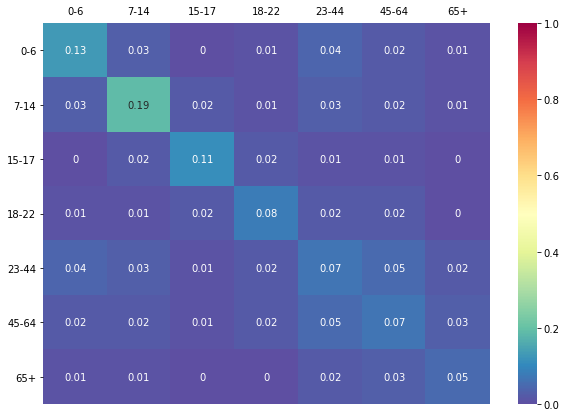

In [68]:
plt.figure(figsize=(10,7))
sns.heatmap(np.round(C,2), annot=True, vmin=0, vmax=1, cmap="Spectral_r", xticklabels=labels, yticklabels=labels)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.yticks(rotation=0)
plt.show()